In [1]:
import os
from constants import *

os.environ["PPLX_API_KEY"] = PPLX_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

In [2]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from langchain_openai import OpenAIEmbeddings
import datamapplot

import pandas as pd
import numpy as np
import asyncio
import pickle

/home/eric/Desktop/NeurIPS-2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ast
example_df = pd.read_csv("climate.csv")

example_df["extraction"] = example_df["extraction"].apply(ast.literal_eval) # bodge to deal with csv storage
example_df["full_text"] = example_df['post_title'] + "\n\n" + example_df['self_text']

In [4]:
example_df[:3]

,Unnamed: 0,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,...,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,extraction,full_text
0,337451,kfzmufh,12,"Nothing in particular, just that I've noticed ...",climate,2024-01-02 15:56:17,18wpy55,blackcatwizard,0,12,...,30563.0,221,NaN,Hannah Ritchie: ‘Doomsday predictions are a dr...,0.87,221,0,2024-01-02 13:54:01,[Skepticism towards doomsday predictions and t...,Hannah Ritchie: ‘Doomsday predictions are a dr...
1,35169,l5xf5c3,12,Most people wanna shout about ‘morals!’ Until ...,climate,2024-05-27 20:02:32,1d1qnci,HumanityHasFailedUs,0,12,...,26298.0,464,NaN,World has ‘moral responsibility’ to help small...,0.95,464,0,2024-05-27 12:43:00,"[People often express moral outrage, but are u...",World has ‘moral responsibility’ to help small...
2,24067,l6kgwb6,7,Man I hope Biden wins.,climate,2024-06-01 02:19:27,1d53m9f,Squibbles01,0,7,...,85978.0,3051,NaN,Project 2025 plans to dismantle the federal ag...,0.96,3051,0,2024-05-31 19:13:02,[Criticism of right-wing media's attacks on cl...,Project 2025 plans to dismantle the federal ag...


## Text Processing

In [5]:
# LLM extracted docs
docs = example_df["extraction"].to_list()
docs = [d for ds in docs for d in ds]  # flatten
docs[:3]

['Skepticism towards doomsday predictions and their potential impact on addressing the climate crisis.',
 'Possibly critical of the use of doomsday predictions as a means to raise awareness about climate change.',
 'People often express moral outrage, but are unwilling to take concrete actions.']

Lines indicate code that is expensive to run, and thus can be skipped and loaded from file.

---

In [6]:
full_text = example_df["full_text"].to_list()
full_text[0]

"Hannah Ritchie: ‘Doomsday predictions are a dream for climate deniers’ | Climate crisis\n\nNothing in particular, just that I've noticed it several times and I think twice in this sub."

In [7]:
import re
def clean_text(text):
    # keep handles for model
    #text = re.sub("@\w+", "", text) # Remove handle   

    text = re.sub("[^\x20-\x7E]", "", text) # limit to ascii
    text = re.sub('http\S+', "", text)  # remove https

    return text

In [9]:
## Baseline doc sentence segmentation appraoch

"""
nlp = spacy.load("en_core_web_sm")

cleaned_text = [clean_text(c) for c in full_text]  # Clean the text

tokenized_text = []
for t in cleaned_text:
    t_nlp = nlp(t)
    tokenized_text += [s.text for s in t_nlp.sents]
"""

## Baseline doc semantic chunking appraoch

from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings  # for speed; or use OpenAI

embedding_model = FastEmbedEmbeddings()
segchunker = SemanticChunker(embedding_model, breakpoint_threshold_type="percentile")

cleaned_text = [clean_text(c) for c in full_text] 
tokenized_text = segchunker.create_documents(cleaned_text)
tokenized_text = [d.page_content for d in tokenized_text]

with open("seg-docs", "wb") as fp:
   pickle.dump(tokenized_text, fp)

tokenized_text[:3]


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 65741.44it/s]


["Hannah Ritchie: Doomsday predictions are a dream for climate deniers | Climate crisisNothing in particular, just that I've noticed it several times and I think twice in this sub.",
 'World has moral responsibility to help small island states survive climate crisis  UN agency chief | Global developmentMost people wanna shout about morals! Until it requires them to actually do something, then not so much.',
 'Everyone wants change, no one wants to change. Said someone, somewhere, probably.']

## Clustering

In [16]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

base_embed = embedding_model.embed_documents(tokenized_text)
embed = embedding_model.embed_documents(docs)
base_embed = np.array(base_embed)
embed = np.array(embed)

In [17]:
### Semantic Chunks

# Text Statistics
print("Num Sentences:", len(tokenized_text))
print("Chunk Length Statistics")
print(pd.Series(tokenized_text).apply(len).describe())

# Calculate Topics
base_cluster_model = HDBSCAN(min_cluster_size=5, approx_min_span_tree=False)
base_topic_model = BERTopic(hdbscan_model=base_cluster_model, embedding_model=embedding_model)
base_topics, base_probs = base_topic_model.fit_transform(tokenized_text, embeddings=base_embed)

# Reduce Outliers
#base_new_topics = base_topic_model.reduce_outliers(tokenized_text, base_topics, strategy="c-tf-idf")
#base_topic_model.update_topics(tokenized_text, topics=base_new_topics)

base_topic_model.save("topic-models/seg-topic-model", serialization="safetensors", save_ctfidf=True)

Num Sentences: 2856
Chunk Length Statistics
count    2856.000000
mean      234.153711
std       248.449295
min         0.000000
25%       110.750000
50%       182.000000
75%       286.000000
max      4621.000000
dtype: float64


/home/eric/Desktop/NeurIPS-2024/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [18]:
### LLM Simplified

# Text Statistics
print("Num Statements:", len(docs))
print("LLM Extracted Text Statistics:")
print(pd.Series(docs).apply(len).describe())

# Calculate Topics
cluster_model = HDBSCAN(min_cluster_size=10, approx_min_span_tree=False)
topic_model = BERTopic(hdbscan_model=cluster_model, embedding_model=embedding_model)
topics, probs = topic_model.fit_transform(docs, embeddings=embed)

# Reduce Outliers
#new_topics = topic_model.reduce_outliers(tokenized_text, base_topics, strategy="c-tf-idf")
#topic_model.update_topics(tokenized_text, topics=base_new_topics)

topic_model.save("topic-models/llm-topic-model", serialization="safetensors", save_ctfidf=True)

Num Statements: 6416
LLM Extracted Text Statistics:
count    6416.000000
mean       85.762001
std        27.622964
min        14.000000
25%        66.000000
50%        82.000000
75%       101.000000
max       253.000000
dtype: float64


---

In [6]:
# Load models and semantic chunks

with open("seg-docs", "rb") as fp:
   tokenized_text = pickle.load(fp)

base_topic_model = BERTopic.load("topic-models/seg-topic-model")
topic_model = BERTopic.load("topic-models/llm-topic-model")

In [7]:
# Skip if already calculated

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

base_embed = embedding_model.embed_documents(tokenized_text)
embed = embedding_model.embed_documents(docs)
base_embed = np.array(base_embed)
embed = np.array(embed)

In [8]:
from umap import UMAP

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embed)
base_reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(base_embed)

/home/eric/Desktop/NeurIPS-2024/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
base_topic_info = base_topic_model.get_topic_info()
base_topic_info.to_html("figures/seg-topic-clusters.html")
base_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,868,-1_we_the_and_of,"[we, the, and, of, in, it, to, that, is, are]",NaN
1,0,49,0_thanks_go_lunch_rite,"[thanks, go, lunch, rite, rotlmaohis, pardon, ...",NaN
2,1,41,1_florida_desantis_state_bill,"[florida, desantis, state, bill, scrubbing, si...",NaN
3,2,34,2_collapse_hopeless_adapt_broken,"[collapse, hopeless, adapt, broken, prepared, ...",NaN
4,3,34,3_cop28_fossil_fuels_deal,"[cop28, fossil, fuels, deal, agreement, phaseo...",NaN
...,...,...,...,...,...
148,147,5,147_transitioning_impossible_breakdown_plant,"[transitioning, impossible, breakdown, plant, ...",NaN
149,148,5,148_gasoline_canada_2031_cars,"[gasoline, canada, 2031, cars, zero, must, new...",NaN
150,149,5,149_sea_levels_south_rise,"[sea, levels, south, rise, heres, starting, fa...",NaN
151,150,5,150_vote_voter_turnout_persuasion,"[vote, voter, turnout, persuasion, stinnett, n...",NaN


In [10]:
topic_info = topic_model.get_topic_info()
topic_info.to_html("figures/llm-topic-clusters.html")
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2010,-1_the_of_that_author,"[the, of, that, author, change, to, and, is, c...",NaN
1,0,288,0_meat_plant_based_animal,"[meat, plant, based, animal, food, veganism, d...",NaN
2,1,159,1_trump_presidency_donald_actions,"[trump, presidency, donald, actions, would, po...",NaN
3,2,134,2_humorous_tone_humor_lighthearted,"[humorous, tone, humor, lighthearted, sarcasti...",NaN
4,3,130,3_optimistic_hope_hopeful_positive,"[optimistic, hope, hopeful, positive, progress...",NaN
...,...,...,...,...,...
115,114,11,114_coal_worse_lng_natural,"[coal, worse, lng, natural, exports, destinati...",NaN
116,115,11,115_drought_panama_canal_supply,"[drought, panama, canal, supply, water, unprec...",NaN
117,116,11,116_degrowth_retraction_necessary_economic,"[degrowth, retraction, necessary, economic, wi...",NaN
118,117,11,117_billionaires_taxing_poorest_tax,"[billionaires, taxing, poorest, tax, protect, ...",NaN


In [22]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

# 10 topics in representation
dv = TopicDiversity(topk=10)

base_topic_matrix = {
    'topics': base_topic_info["Representation"][1:].to_list()
}
topic_matrix = {
    'topics': topic_info["Representation"][1:].to_list()
}

print("Topic Diversity Values:")
print("Semantic Chunking:", dv.score(base_topic_matrix))
print("LLM Extraction:", dv.score(topic_matrix))

Topic Diversity Values:
Semantic Chunking: 0.8394736842105263
LLM Extraction: 0.7596638655462185


Seg Wordclouds


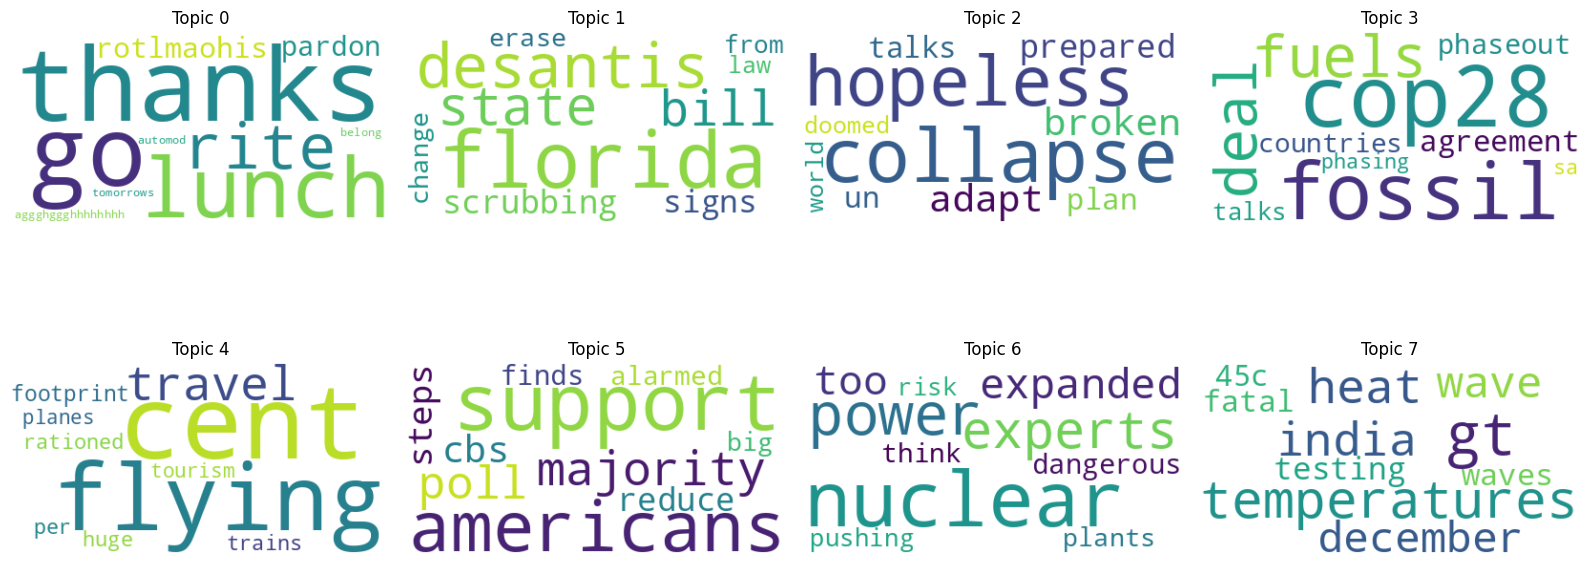

LLM Wordclouds


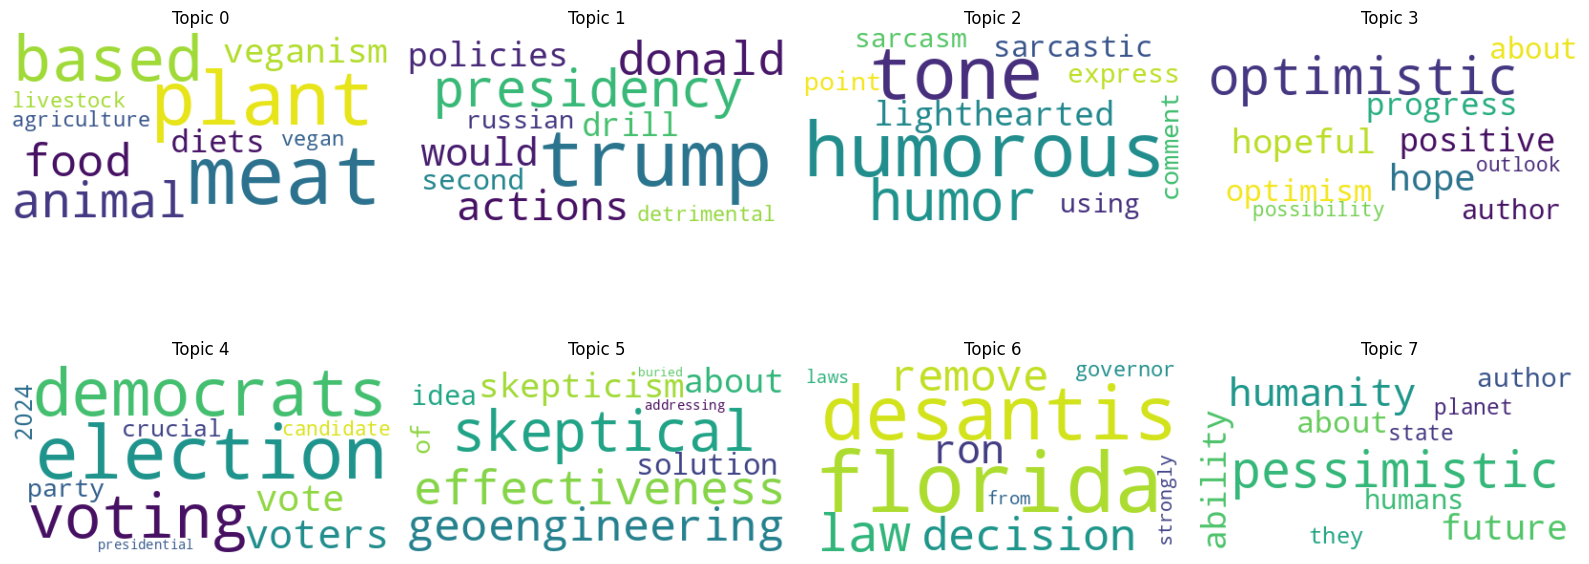

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordclouds(model, topics, width=4):
    fig = plt.figure(figsize=(16,8))

    num_subplots = len(topics)
    h = int(np.ceil(num_subplots/width))

    for i,t in enumerate(topics):
        text = {word: value for word, value in model.get_topic(t)}

        plt.subplot(h, 4, i+1).set_title(f"Topic {t}")
        wc = WordCloud(background_color="white", max_words=1000)
        wc.generate_from_frequencies(text)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")

    fig.tight_layout()

print("Seg Wordclouds")
create_wordclouds(base_topic_model, [0,1,2,3,4,5,6,7])
plt.savefig("figures/seg-topic-wordclouds.png")
plt.show()

print("LLM Wordclouds")
create_wordclouds(topic_model, [0,1,2,3,4,5,6,7])
plt.savefig("figures/llm-topic-wordclouds.png")
plt.show()


In [24]:
base_visual_docs = base_topic_model.visualize_documents(tokenized_text, embeddings=base_embed, hide_annotations=True, title='<b>Semantically Chunked Documents and Topics</b>')
base_visual_docs.write_html("figures/seg-visual-docs.html")
base_visual_docs

In [25]:
visual_docs = topic_model.visualize_documents(docs, embeddings=embed, hide_annotations=True, title='<b>LLM Extracted Documents and Topics</b>')
visual_docs.write_html("figures/llm-visual-docs.html")
visual_docs

In [15]:
# Visualize topics over time
extraction_timestamps = [[time]*lex for time,lex in zip(example_df['created_time'], example_df["extraction"].apply(len))]
times = [t for ts in extraction_timestamps for t in ts]

topics_over_time = topic_model.topics_over_time(docs, times, nr_bins=20)

In [17]:
llm_over_time_fig = topic_model.visualize_topics_over_time(
    topics_over_time,
    topics = [1,2,3,4,5,6,7],
    top_n_topics=30,
    width=1200,
    height=900,
    title='<b>LLM Extracted Topics over Time</b>'
)
llm_over_time_fig.write_html("figures/llm-timestamp-fig.html")
llm_over_time_fig

In [29]:
h_topics = topic_model.hierarchical_topics(docs)
topic_tree = topic_model.visualize_hierarchy(hierarchical_topics=h_topics)
topic_tree.write_html("figures/llm-topic-tree-fig.html")
topic_tree

100%|██████████| 118/118 [00:00<00:00, 384.82it/s]
